In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import networkx as nx
import matplotlib.pyplot as plt
import time

# modules specific to this project
import network as nw
import physics
import timemarching as tm
import plotter
import logger


### 1. Define the broadcasting channels of the network
This is done by creating a list of the channel names. The names are arbitrary and can be set by the user, such as 'postive', 'negative' or explicit wavelenghts like '870 nm', '700 nm'. Here I chose the colors 'red' and 'blue'.

In [2]:
channel_list = ['red', 'blue']
# Automatically generate the object that handles them
channels = {channel_list[v] : v for v in range(len(channel_list))}

### 2. Define the layers
Define the layers of nodes in terms of how they are connected to the channels. Layers and weights are organized in dictionaries. The input and output layers do not need to be changed, but for the hidden layer we need to specify the number of nodes N and assign the correct channels to the input/output of the node.

In [3]:
# Create layers ordered from 0 to P organized in a dictionary
layers = {} 
Nring=5
# An input layer automatically creates on node for each channel that we define
layers[0] = nw.InputLayer(input_channels=channels)
# Forward signal layer
layers[1] = nw.HiddenLayer(N=1, output_channel='blue',excitation_channel='blue',inhibition_channel='red')
# Inhibiting memory layer
layers[2] = nw.HiddenLayer(N=1, output_channel='red' ,excitation_channel='blue',inhibition_channel='red')
layers[3] = nw.OutputLayer(output_channels=channels) # similar to input layer

### 3. Define existing connections between layers
The weights are set in two steps. 
First the connetions between layers are defined. This should be done using the keys defined for each layer above, i.e. 0, 1, 2 ... for input, hidden and output layers, respectively. The `connect_layers` function returns a weight matrix object that we store under a chosen key, for example `'inp->hid'`.
Second, the specific connections on the node-to-node level are specified using the node index in each layer

In [4]:
# Define the overall connectivity
weights = {}
# The syntax is connect_layers(from_layer, to_layer, layers, channels)
weights['inp->hd0'] = nw.connect_layers(0, 1, layers, channels)
#weights['inp->hd1'] = nw.connect_layers(0, 2, layers, channels)
weights['hd0->hd1'] = nw.connect_layers(1, 2, layers, channels)
weights['hd0->out'] = nw.connect_layers(1, 3, layers, channels)
#weights['hd1->out'] = nw.connect_layers(2, 3, layers, channels)
# Backwards connection from the memory
weights['hd1->hd0'] = nw.connect_layers(2, 1, layers, channels)

# Define the specific node-to-node connections in the weight matrices
low_weight =  0.005 # 0.02
# The syntax is connect_nodes(from_node, to_node, channel=label, weight=value in weight matrix)

# Draw a ring network with Nring nodes (Nring defined above)

# Input to first ring layer node
weights['inp->hd0'].connect_nodes(channels['blue'] ,0, channel='blue', weight=1.0) # channels['blue']=1
weights['inp->hd0'].connect_nodes(channels['red'] ,0, channel='red', weight=1.0) # channels['blue']=1
# Connect second hidden layer
#weights['inp->hd1'].connect_nodes(channels['blue'] ,0, channel='blue', weight=1.0) # channels['blue']=1
# Hidden layer connections
weights['hd0->hd1'].connect_nodes(0 ,0 , channel='blue', weight=low_weight) 
# Add damping connection
#weights['hd1->hd0'].connect_nodes(0 ,0 , channel='red', weight=low_weight)    
# Connect to output
weights['hd0->out'].connect_nodes(0, channels['blue'], channel='blue', weight=0.9)
#weights['hd1->out'].connect_nodes(0, channels['red'], channel='red', weight=0.9)


0

### 4. Visualize the network 
The `plotter` module supplies functions to visualize the network structure. The nodes are named by the layer type (Input, Hidden or Output) and the index. To supress the printing of weight values on each connection, please supply `show_edge_labels=False`.

#### Available layouts:
**multipartite**: Standard neural network appearance. Hard to see recurrent couplings within layers.  
**circular**: Nodes drawn as a circle  
**shell**: Layers drawn as concetric circles  
**kamada_kawai**: Optimization to minimize weighted internode distance in graph  
**spring**: Spring layout which is standard in `networkx` 

#### Shell layout
This is my current favorite. It is configured to plot the input and output nodes on the outside of the hidden layer circle, in a combined outer concentric circle.

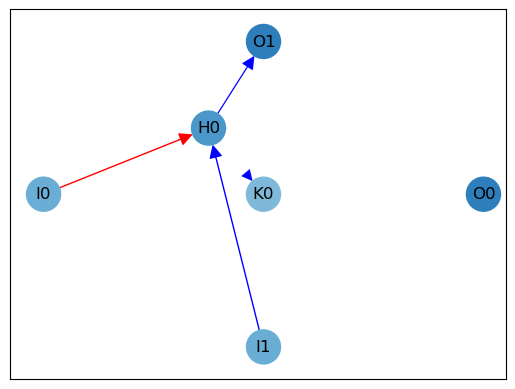

In [5]:
plotter.visualize_network(layers, weights, layout='shell', show_edge_labels=False)

### 5. Specify the physics of the nodes
Before running any simulations, we need to specify the input currents and the physics of the hidden layer nodes. Parameters can either be specified directly or coupled from the `physics` module. 

In [19]:
# An slow rising current pulse to adiabatically probe the activation function
def triangle_pulse(t, args) :
    # unpack here
    tstart, tend, Imax = args
    if t>tstart :
        return Imax*(t-tstart)/(tend-tstart)
    else :
        return 0
        

In [23]:
# Specify an exciting current square pulse and a constant inhibition
# Pulse train of 1 ns pulses
t_blue = [(6.0,7.0), (11.0,12.0), (16.0,17.0)] # at 6 ns, 11 ns, and 16 ns
t_blue = [(5.0,15.0)]#, (11.0,12.0), (16.0,17.0)] # at 6 ns, 11 ns, and 16 ns
I_blue = 2.3 # nA

# Try to modulate the nodes with red input
t_red = [(8.0,9.0), (12.0,13.0)] # at 6 ns, 11 ns, and 16 ns
# Constant inhibition to stabilize circuit
I_red = 0.0 # nA

# Use the square pulse function and specify which node in the input layer gets which pulse
layers[0].set_input_func(channel='blue',func_handle=triangle_pulse, func_args=(25.0,100.0,4.0))
# Use the costant function to specify the inhibition from I0 to H0
#layers[0].set_input_func(channel='red', func_handle=physics.constant, func_args=I_red)
layers[0].set_input_func(channel='red', func_handle=physics.square_pulse, func_args=(t_red, I_red))

In [8]:
# Specify two types of devices for the hidden layer
# 1. Propagator (standard parameters)
propagator = physics.Device('device_parameters.txt')
propagator.print_parameter('Cstore')
propagator.set_parameter('Rstore',1e6)
# 2. Memory (modify the parameters)
memory = physics.Device('device_parameters.txt')
memory.set_parameter('Rstore',1e6)
#memory.set_parameter('Cstore',2e-15)
# a 3e-15 F capacitor can be build by 800x900 plates 20 nm apart
memory.print_parameter('Cstore')

The parameter Cstore=7e-17 F
The parameter Cstore=7e-17 F


In [9]:
# Specify the internal dynamics by supplying the RC constants to the hidden layer (six parameters)
layers[1].set_gammas(propagator.gammas())
layers[2].set_gammas(memory.gammas())
# Specify the transistor mapping Vgate on each node to the source-drain current Isd (function handle)
layers[1].func_Vgate_to_Isd = propagator.transistorIV
layers[2].func_Vgate_to_Isd = memory.transistorIV

# Specify the LED efficiency function
layers[1].func_eta_LED = propagator.eta_ABC
layers[2].func_eta_LED = memory.eta_ABC
  
# Calculate the unity_coeff to scale the weights accordingly
unity_coeff = propagator.unity_coupling_coefficient(propagator.eta_ABC)
print(f'Unity coupling coefficient calculated as unity_coeff={unity_coeff:.4f}')

Found max eta of 0.64722940236875
Unity coupling coefficient calculated as unity_coeff=0.0316


### 6. Evolve in time

In [24]:
# Start time t, end time T
t = 0.0
T = 105.0 # ns
# To sample result over a fixed time-step, use savetime
savestep = 0.1
savetime = savestep
# These parameters are used to determine an appropriate time step each update
dtmax = 0.1 # ns 
dVmax = 0.005 # V

nw.reset(layers)
# Create a log over the dynamic data
time_log = logger.Logger(layers,channels) # might need some flags

start = time.time()

while t < T:
    # evolve by calculating derivatives, provides dt
    dt = tm.evolve(t, layers, dVmax, dtmax )

    # update with explicit Euler using dt
    # supplying the unity_coeff here to scale the weights
    tm.update(dt, t, layers, weights, unity_coeff)
    
    t += dt
    # Log the progress
    if t > savetime :
        # Put log update here to have (more or less) fixed sample rate
        # Now this is only to check progress
        print(f'Time at t={t} ns') 
        savetime += savestep
    
    time_log.add_tstep(t, layers, unity_coeff)

end = time.time()
print('Time used:',end-start)

# This is a large pandas data frame of all system variables
result = time_log.get_timelog()

Time at t=0.2 ns
Time at t=0.30000000000000004 ns
Time at t=0.4 ns
Time at t=0.5 ns
Time at t=0.6 ns
Time at t=0.7 ns
Time at t=0.7999999999999999 ns
Time at t=0.8999999999999999 ns
Time at t=0.9999999999999999 ns
Time at t=1.0999999999999999 ns
Time at t=1.2 ns
Time at t=1.3 ns
Time at t=1.4000000000000001 ns
Time at t=1.5000000000000002 ns
Time at t=1.6000000000000003 ns
Time at t=1.7000000000000004 ns
Time at t=1.7876931900664328 ns
Time at t=1.848906065877532 ns
Time at t=1.936655260169264 ns
Time at t=2.0856400958118817 ns
Time at t=2.146807370315151 ns
Time at t=2.234644260031109 ns
Time at t=2.383664826166162 ns
Time at t=2.444799470200449 ns
Time at t=2.532699304590494 ns
Time at t=2.681745579214322 ns
Time at t=2.7428568700649114 ns
Time at t=2.8308018526930354 ns
Time at t=2.979866599307468 ns
Time at t=3.040961174298987 ns
Time at t=3.128938524551451 ns
Time at t=3.2780165305483364 ns
Time at t=3.3390991393726424 ns
Time at t=3.4270996865095236 ns
Time at t=3.576187203537953

Time at t=44.03300202091579 ns
Time at t=44.13300202091579 ns
Time at t=44.28874968612468 ns
Time at t=44.34442381671115 ns
Time at t=44.44442381671115 ns
Time at t=44.50017432971041 ns
Time at t=44.60017432971041 ns
Time at t=44.75583797196511 ns
Time at t=44.81159491901446 ns
Time at t=44.91159491901446 ns
Time at t=45.067247111152845 ns
Time at t=45.12301431624889 ns
Time at t=45.22301431624889 ns
Time at t=45.378653008091966 ns
Time at t=45.434435010511855 ns
Time at t=45.53443501051186 ns
Time at t=45.69005685250645 ns
Time at t=45.74585935229009 ns
Time at t=45.84585935229009 ns
Time at t=45.90145928967422 ns
Time at t=46.00145928967422 ns
Time at t=46.157289739006764 ns
Time at t=46.212860394875094 ns
Time at t=46.312860394875095 ns
Time at t=46.46872883925795 ns
Time at t=46.52425960105294 ns
Time at t=46.62425960105294 ns
Time at t=46.780179905111865 ns
Time at t=46.835655578051025 ns
Time at t=46.935655578051026 ns
Time at t=47.09164724214903 ns
Time at t=47.14704606534916 ns

Time at t=75.30171494919232 ns
Time at t=75.40727057121289 ns
Time at t=75.51078561055009 ns
Time at t=75.61237437473366 ns
Time at t=75.71214086379774 ns
Time at t=75.81018002793404 ns
Time at t=75.90657883429587 ns
Time at t=76.00141717722542 ns
Time at t=76.11018753362222 ns
Time at t=76.20188990692458 ns
Time at t=76.30717906657138 ns
Time at t=76.41072725525346 ns
Time at t=76.51261826910633 ns
Time at t=76.61292938192165 ns
Time at t=76.71173203511994 ns
Time at t=76.80909243656222 ns
Time at t=76.90507208251078 ns
Time at t=77.0131456353457 ns
Time at t=77.10635434495693 ns
Time at t=77.2113955516175 ns
Time at t=77.30206065473298 ns
Time at t=77.4043116577289 ns
Time at t=77.5051627625068 ns
Time at t=77.60467003082483 ns
Time at t=77.70288587612275 ns
Time at t=77.81189605001305 ns
Time at t=77.90752684318134 ns
Time at t=78.00200985529418 ns
Time at t=78.10698152316301 ns
Time at t=78.21060568143814 ns
Time at t=78.30162583333798 ns
Time at t=78.40284042556625 ns
Time at t=78

Time at t=102.00006542581964 ns
Time at t=102.10245164404432 ns
Time at t=102.2016007451106 ns
Time at t=102.30044542674115 ns
Time at t=102.40188226304049 ns
Time at t=102.50011767527688 ns
Time at t=102.60093309513246 ns
Time at t=102.70143763864523 ns
Time at t=102.80163416432292 ns
Time at t=102.9015254871311 ns
Time at t=103.00111437941605 ns
Time at t=103.10040357180296 ns
Time at t=103.20221976432694 ns
Time at t=103.3009092145025 ns
Time at t=103.40211409374662 ns
Time at t=103.50021454094671 ns
Time at t=103.60081898838867 ns
Time at t=103.70112304660418 ns
Time at t=103.8011293905983 ns
Time at t=103.90084065590591 ns
Time at t=104.00025943940287 ns
Time at t=104.10213776541886 ns
Time at t=104.20097127749898 ns
Time at t=104.30225336329677 ns
Time at t=104.40051182092604 ns
Time at t=104.50120801473167 ns
Time at t=104.6016111063896 ns
Time at t=104.70172364074251 ns
Time at t=104.80154812601732 ns
Time at t=104.90108703455864 ns
Time at t=105.0003428035435 ns
Time used: 1.8

### 7. Visualize results
Plot results specific to certain nodes

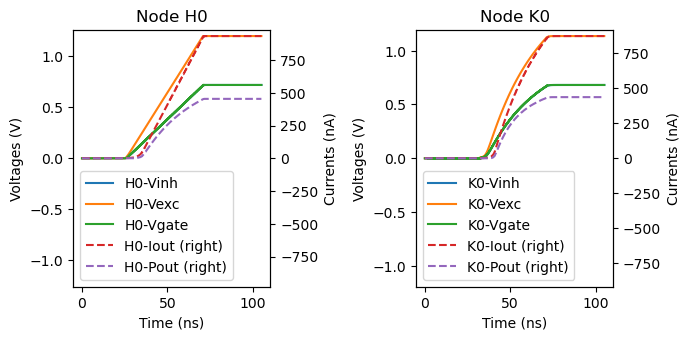

In [25]:
#nodes = ['H0','H1','H2','H3','H4']

nodes = ['H0','K0']
plotter.plot_nodes(result, nodes)

For this system it's quite elegant to use the `plot_chainlist` function, taking as arguments a graph object, the source node (I1 for blue) and a target node (O1 for blue)

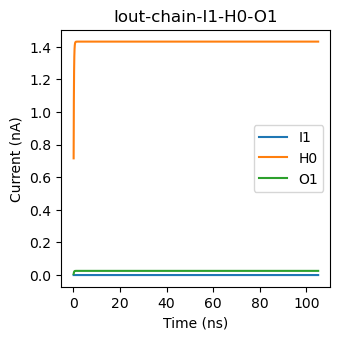

In [12]:
# Variable G contains a graph object descibing the network
G = plotter.retrieve_G(layers, weights)
plotter.plot_chainlist(result,G,'I1','O1')

Plot specific attributes

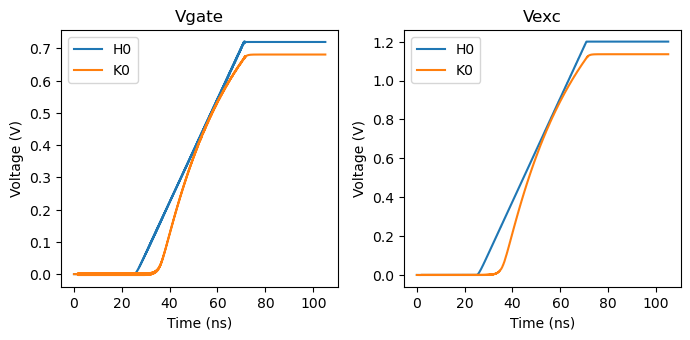

In [30]:
attr_list = ['Vgate','Vexc']
plotter.plot_attributes(result, attr_list)

We can be totally specific if we want. First we list the available columns to choose from

In [26]:
print(result.columns)

Index(['Time', 'I0-Iout-red', 'I1-Iout-blue', 'H0-Vinh', 'H0-Vexc', 'H0-Vgate',
       'H0-Iinh', 'H0-Iexc', 'H0-Iout', 'H0-ISD', 'H0-Pout', 'K0-Vinh',
       'K0-Vexc', 'K0-Vgate', 'K0-Iinh', 'K0-Iexc', 'K0-Iout', 'K0-ISD',
       'K0-Pout', 'O0-Iout-red', 'O1-Iout-blue'],
      dtype='object')


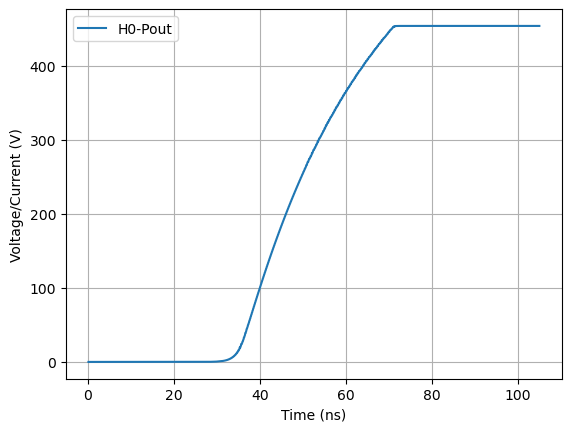

In [28]:
plotter.visualize_dynamic_result(result, ['H0-Pout'])

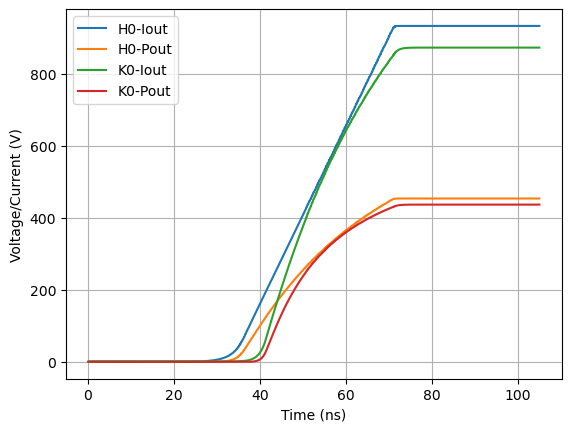

In [29]:
plotter.visualize_dynamic_result(result, ['H0-Iout','H0-Pout','K0-Iout','K0-Pout'])

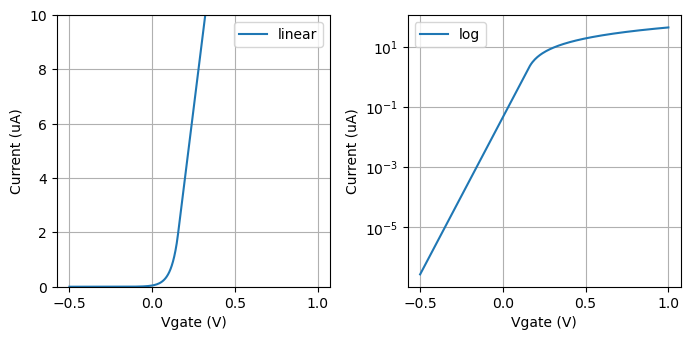

In [17]:
plotter.visualize_transistor(propagator.transistorIV,propagator.transistorIV_example())

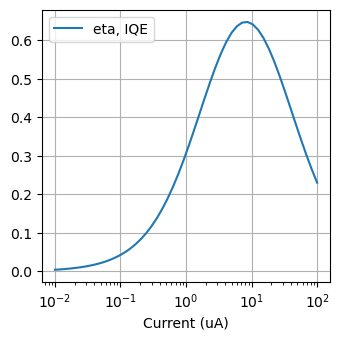

In [18]:
plotter.visualize_LED_efficiency(propagator.eta_example(propagator.eta_ABC))